<a href="https://colab.research.google.com/github/una12343/MIEP/blob/main/BreastCancerWisconsin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analiza i Klasifikacija Tumora Dojke**

Rak dojke je jedan od najčešćih oblika raka kod žena širom sveta. Rano otkrivanje i dijagnoza su ključni za uspešno lečenje i preživljavanje. Mamografija je najčešća metoda za rano otkrivanje raka dojke. Klasifikacija gustine dojke prema ACR (American College of Radiology) standardu je važan korak u analizi mamograma. U ovom projektu ćemo koristiti Breast Cancer Wisconsin dataset, koji je jedan od najpoznatijih i najčešće korišćenih skupova podataka za klasifikaciju raka dojke. Cilj je da se izgradi model zasnovan na jednostavnoj neuronskoj mreži koji može klasifikovati tumore kao benigni ili maligni sa visokom tačnošću. Pored toga, istražićemo distribuciju karakteristika podataka kroz različite vizualizacije kako bismo bolje razumeli strukturu podataka i njihov uticaj na klasifikaciju.

**Dataset**

Breast Cancer Wisconsin Dataset je široko korišćen skup podataka za klasifikaciju raka dojke. Dataset sadrži 569 uzoraka sa 30 numeričkih karakteristika, uključujući:
*   Radius
*   Tekstura
*   Perimetar
*   Površina
*   Glatkoća
*   Kompaknost
*   Konkavnost
*   Konkavne tačke
*   Simetrija
*   Fraktana dimenzija

Ciljna promenljiva:

*   diagnosis: Klasa dijagnoze (B - Benigni, M - Maligni)







Prvi korak predstavlja instalaciju potrebnih biblioteka

In [1]:
# Instalacija potrebnih biblioteka
!pip install pandas matplotlib seaborn scikit-learn torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Kako se dataset učitava na google drive-u potrebno je i povezati sa istim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Učitavanje Breast Cancer Wisconsin Dataset-a

In [4]:

data_path = '/content/drive/MyDrive/breast_cancer/data.csv'
df = pd.read_csv(data_path)


Ovaj korak uključuje učitavanje podataka, izbacivanje nepotrebnih kolona, preimenovanje ciljne kolone, mapiranje dijagnoza u numeričke vrednosti i podelu podataka na trening i test setove.

In [5]:
# Prikaz osnovnih informacija o podacima
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Ovaj korak generiše histograme za svaku karakteristiku (kolonu) u datasetu. Histogrami pokazuju distribuciju vrijednosti svake karakteristike preko svih uzoraka u datasetu.
Histogrami pomažu da se vidi kako su vrijednosti raspodeljene za svaku karakteristiku, da li su normalno raspodeljene, da li ima outlier-a (izuzetaka) ili skupova sa specifičnim raspodelama.

<Figure size 2000x1500 with 0 Axes>

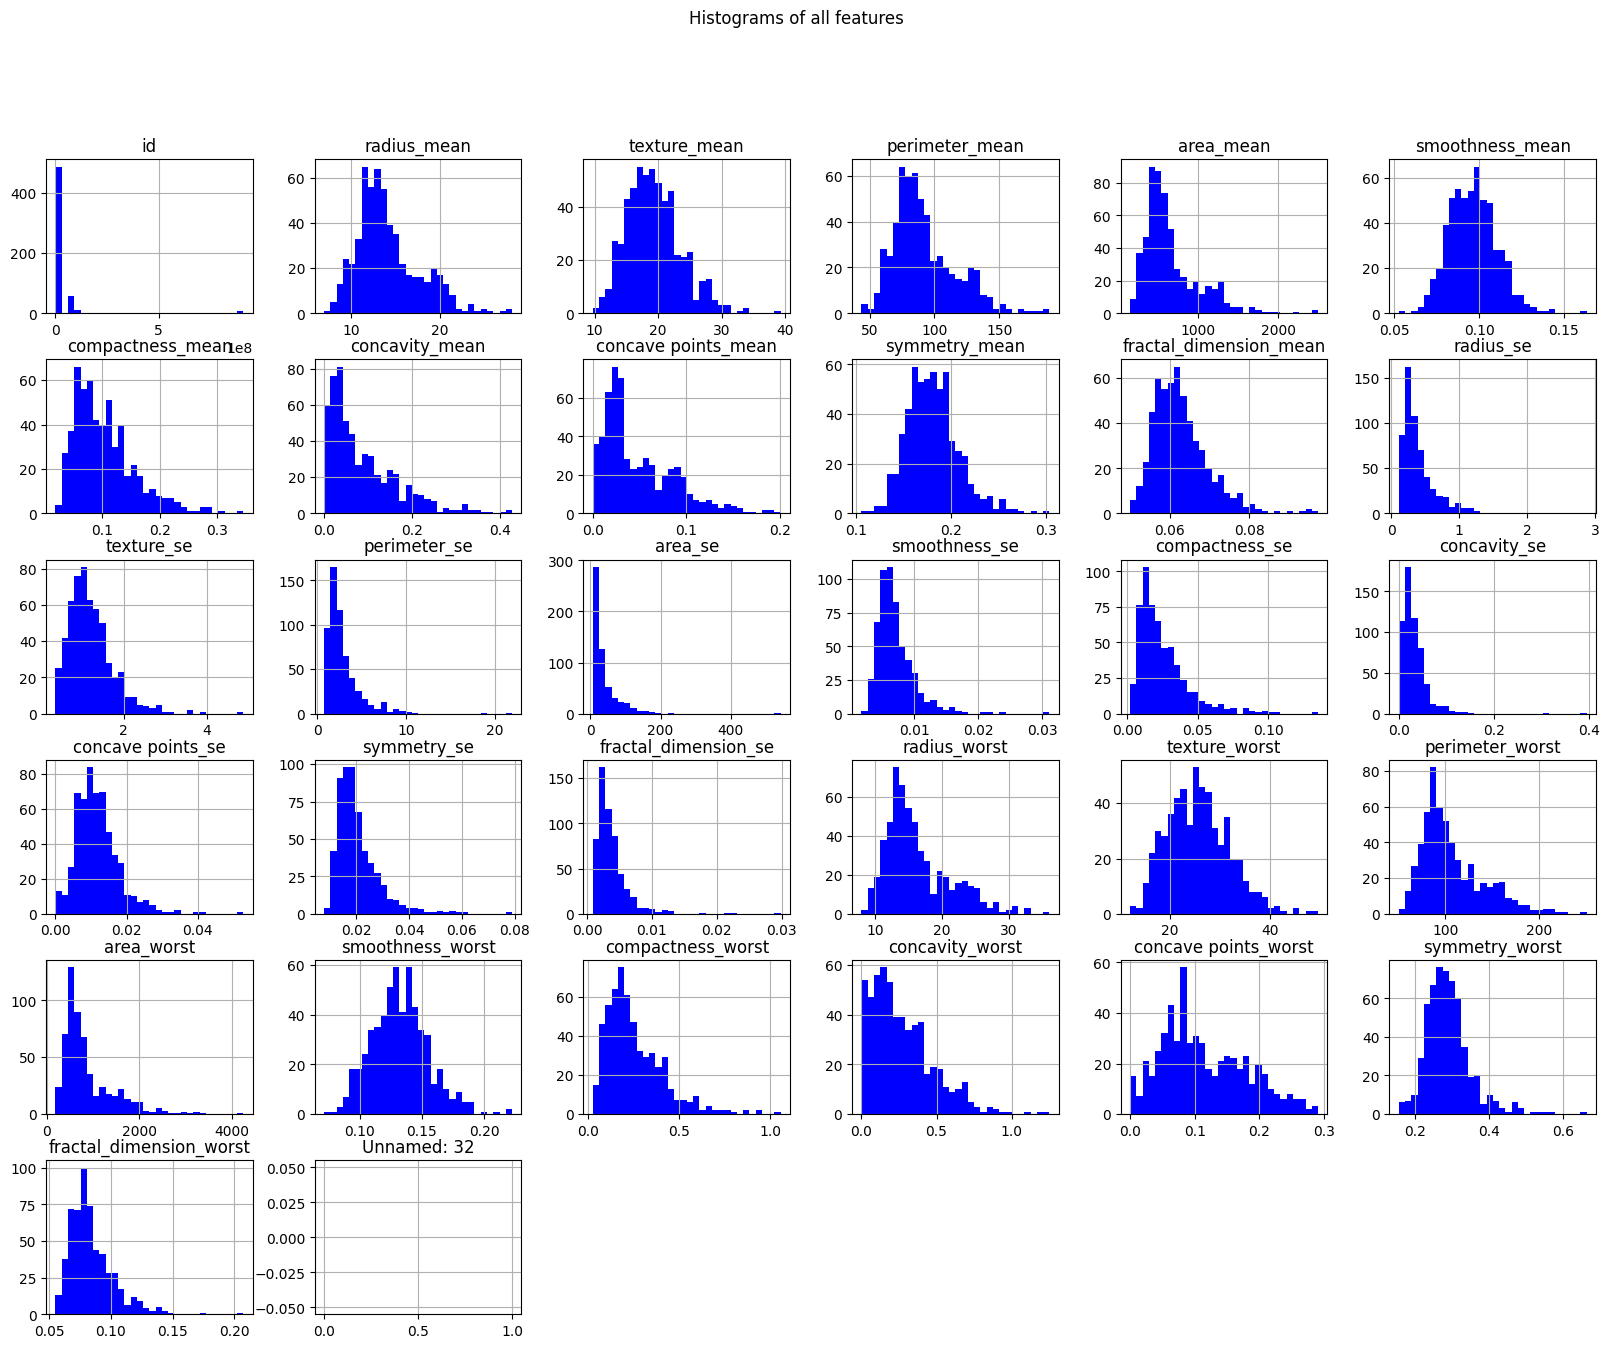

In [6]:
# Vizualizacija distribucije karakteristika
plt.figure(figsize=(20, 15))
df.hist(bins=30, figsize=(20, 15), color='blue')
plt.suptitle("Histograms of all features")
plt.show()

In [9]:
# Izbacivanje beskorisnih kolona
df = df.drop(columns=['id', 'Unnamed: 32'])

df = df.rename(columns={'diagnosis': 'target'})

df['target'] = df['target'].map({'M': 1, 'B': 0})


X = df.drop(columns=['target']).values
y = df['target'].values

# Podela podataka na trening i test setove
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ovaj korak kreira PyTorch Dataset klasu za upravljanje podacima i koristi DataLoader za učitavanje podataka u mini-batch-evima tokom treniranja i testiranja.

In [10]:
class BreastCancerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Kreiranje dataset-a i DataLoader-a
train_dataset = BreastCancerDataset(X_train, y_train)
test_dataset = BreastCancerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Ovaj korak definiše jednostavnu neuronsku mrežu sa tri sloja: dva skrivena sloja sa ReLU aktivacijom i jedan izlazni sloj.

In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2) # 2 klase

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
model = SimpleNN(input_size).to(device)


Ovaj korak uključuje treniranje modela, gde se za svaku epohu računa gubitak i tačnost, a rezultati se ispisuju na kraju svake epohe. Takođe se plotuju gubitak i tačnost kroz epohe.

Epoch [1/10], Loss: 5.5972, Accuracy: 51.6484%
Epoch [2/10], Loss: 2.6025, Accuracy: 55.3846%
Epoch [3/10], Loss: 1.1014, Accuracy: 55.6044%
Epoch [4/10], Loss: 0.4543, Accuracy: 86.3736%
Epoch [5/10], Loss: 0.3912, Accuracy: 86.5934%
Epoch [6/10], Loss: 0.2689, Accuracy: 87.4725%
Epoch [7/10], Loss: 0.2707, Accuracy: 90.7692%
Epoch [8/10], Loss: 0.2917, Accuracy: 90.1099%
Epoch [9/10], Loss: 0.3218, Accuracy: 89.6703%
Epoch [10/10], Loss: 0.3009, Accuracy: 89.8901%


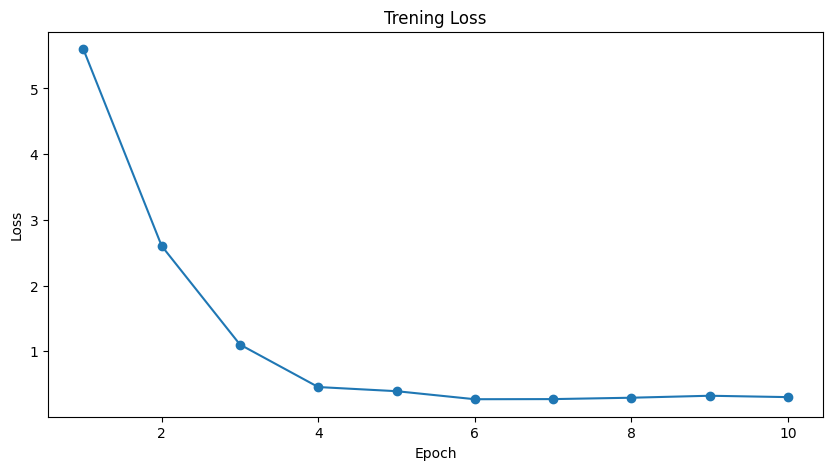

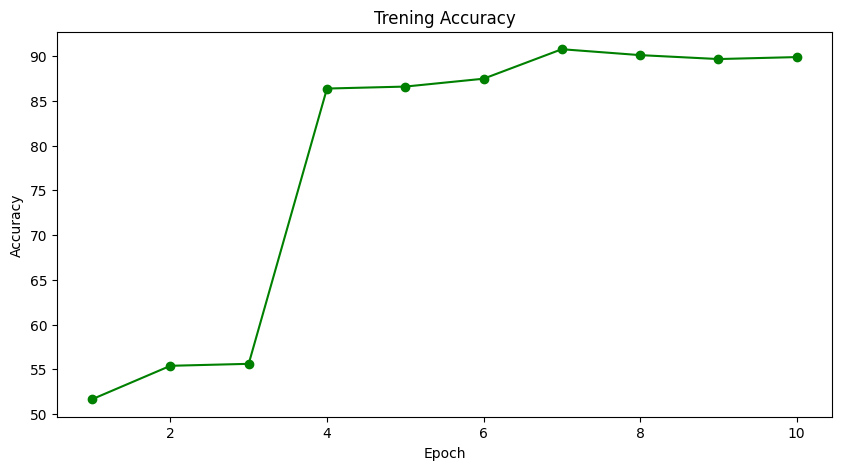

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%")

# Plotovanje gubitka
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("Trening Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plotovanje tačnosti
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='green')
plt.title("Trening Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Ovaj korak uključuje evaluaciju modela na test setu, ispis matrice konfuzije, klasifikacionog izveštaja i tačnosti modela. Vizualizacija matrice konfuzije omogućava bolji uvid u performanse modela.

Confusion Matrix:
[[64  7]
 [ 0 43]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        71
           1       0.86      1.00      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.95      0.94      0.94       114

Test Accuracy: 93.86%


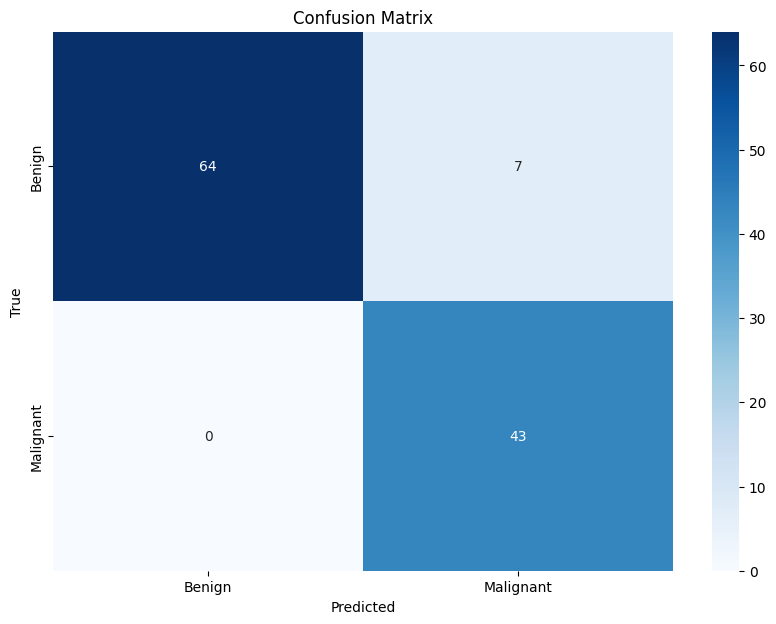

In [14]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Matrica konfuzije je alat koji se koristi za procenu performansi klasifikacionog modela. Omogućava detaljan pregled kako model radi sa svakom klasom posebno, prikazujući tačne i netačne predikcije i prikazuje sledeće informacije:

*   True Negatives (TN): 64 (model je tačno klasifikovao 64 benigni uzorak)
*   False Positives (FP): 7 (model je pogrešno klasifikovao 7 benignih uzoraka kao maligni)
*   False Negatives (FN): 0 (model je pogrešno klasifikovao 0 maligna uzorlakao benigna)
*   True Positives (TP): 43 (model je tačno klasifikovao 43 malignih uzoraka)


Matrica konfuzije prikazana je kao toplotna mapa (heatmap) koja omogućava brzu vizuelnu procenu performansi modela. Plave nijanse označavaju broj tačnih i netačnih predikcija za svaku klasu.



*   **True Negative** (TN): Broj ispravno klasifikovanih negativnih uzoraka (model je tačno predvideo negativne instance).
*   **False Positive** (FP): Broj netačno klasifikovanih negativnih uzoraka (model je pogrešno predvideo negativne instance kao pozitivne).
*   **False Negative** (FN): Broj netačno klasifikovanih pozitivnih uzoraka (model je pogrešno predvideo pozitivne instance kao negativne).
*   **True Positive** (TP): Broj ispravno klasifikovanih pozitivnih uzoraka (model je tačno predvideo pozitivne instance).





# **Zaključak i unaprijeđenje projekta**

Iako je osnovni model jednostavan i pokazuje solidne performanse, postoji nekoliko načina na koje se može unaprijediti model i poboljšati tačnost i efikasnost klasifikacije raka dojke.
Na osnovu istraživačkih radova koji postoje na ovu temu, pored jednostavnih neuronskih mreža, postoje i složeniji modeli koji mogu pružiti bolje rezultate kao što su:

*   **Random Forest** je metoda koja koristi više stabala odlučivanja za klasifikaciju. Svako stablo je trenirano na različitim podskupovima podataka, a konačna predikcija se dobija glasanjem svih stabala.
*   **SVM** je algoritam koji traži hiper-ravan koja najbolje razdvaja klase u visoko-dimenzionalnom prostoru. Može koristiti različite kernel funkcije (linearne, polinomijalne, RBF) za bolje razdvajanje podataka.

*   Dublje i složenije neuronske mreže, kao što su **Convolutional Neural Networks (CNNs)** i **Recurrent Neural Networks (RNNs)**, mogu biti primenjene za poboljšanje performansi. CNNs su posebno korisne za analizu slika, dok su RNNs korisne za sekvencijalne podatke.




